In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime as dt
from wordcloud import WordCloud
from textblob import TextBlob
import ast
import pingouin as pg
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from matplotlib.ticker import FuncFormatter

In [16]:
# Load dataset
fusion = pd.read_csv('/Users/michaeladebayo/Documents/Simplon/brief_projects/movie_prediction/machine_learning/fusionV3_cleaned.csv')

In [17]:
# Convert date columns to datetime objects
for col in ['release_date_france', 'release_date_usa']:
    try:
        fusion[col] = pd.to_datetime(fusion[col], errors='coerce')
    except Exception as e:
        print(f"Error converting column {col}: {e}")

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_17083/4117160534.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fusion[col] = pd.to_datetime(fusion[col], errors='coerce')


In [18]:
# Display max rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# View first 5 rows in dataframe
fusion.head()

,film_id,film_title,image_url,year_of_production,release_date_france,release_date_usa,nationality,languages,duration,age_classification,director,top_stars,producers,main_genre_jpboxoffice,associated_genres_allocine,synopsis,filming_secrets,awards,broadcast_category,distributor,budget,fr_entries,fr_entries_cumul,fr_entry_week,us_entries,us_entry_week,revenue_usa,revenue_world,press_rating,viewer_rating,press_critics_count,viewer_critics_count,trailer_views,release_season,duration_minutes,producers_list,producers_count,top_stars_list,top_stars_count,languages_list,languages_count,nationality_list,nationality_list_count,associated_genres_allocine_list,associated_genres_allocine_count,fr_entry_week_iso_week,us_entry_week_iso_week,filming_secrets_num,opening_week_france_num,opening_week_us_num,press_critics_count_num,award_count,nomination_count,total_awards_nomination,viewer_notes,viewer_critiques,trailer_views_num,synopsis_length,release_date_us
0,20941,"Abigail, le pouvoir de l'Elue",https://www.jpbox-office.com/cinema/images/pos...,2019,2020-08-01,NaT,"U.S.A.,Russie",Anglais,1h 51min,NaN,Aleksandr Boguslavskiy,"Tinatin Dalakishvili,Eddie Marsan,Rinal Mukham...","Aleksandr Boguslavskiy,Dmitriy Zhigalov",Fantasy,"Action,Fantastique","Un siècle après le début de la Contamination, ...",-,NaN,en VOD,Condor Distribution,20000000.0,NaN,NaN,NaN,NaN,NaN,NaN,1835634.0,1.9,1.9,"241 notes, 40 critiques","241 notes, 40 critiques","47 731,vues",Winter,111.0,"['Aleksandr Boguslavskiy', 'Dmitriy Zhigalov']",2,"['Tinatin Dalakishvili', 'Eddie Marsan', 'Rina...",3,['Anglais'],1,"['U.S.A.', 'Russie']",2,"['Action', 'Fantastique']",2,0,0,0,0,0,241,0,0,0,241,40,47731.0,546,NaN
1,10280,Wolfman,https://www.jpbox-office.com/cinema/images/pos...,2010,2010-10-02,2010-12-02,NaN,"Anglais, Roumain",1h 43min,Interdit - 12 ans,Joe Johnston,"Benicio Del Toro,Anthony Hopkins,Emily Blunt","Joe Johnston,Andrew Kevin Walker,David Self",Fantasy,"Fantastique,Epouvante-horreur,Thriller",Lawrence Talbot est un aristocrate torturé que...,9 anecdotes,1 prix et 2 nominations,en salle,Universal Pictures International France,150000000.0,214 497,334 885,10-02-2010 – 17-02-2010,30 627 000,12-02-2010 – 15-02-2010,61937495.0,77810085.0,3.1,2.4,14 critiques,"4274 notes, 791 critiques",NaN,Winter,103.0,"['Joe Johnston', 'Andrew Kevin Walker', 'David...",3,"['Benicio Del Toro', 'Anthony Hopkins', 'Emily...",3,"['Anglais', 'Roumain']",2,[],0,"['Fantastique', 'Epouvante-horreur', 'Thriller']",3,6,6,9,214497,30627000,14,1,2,3,4274,791,NaN,245,NaN
2,19775,L'Art du mensonge,https://www.jpbox-office.com/cinema/images/pos...,2019,2020-01-01,2019-11-15,"U.S.A.,Canada",Anglais,1h 50min,NaN,Bill Condon,"Helen Mirren,Ian McKellen,Russell Tovey","Bill Condon,Jeffrey Hatcher",Drame,"Drame,Thriller","Escroc professionnel, Roy Courtnay a déjà en v...",2 anecdotes,NaN,en salle,Warner Bros. France,10000000.0,66 229,105 205,01-01-2020 – 08-01-2020,5 605 051,15-11-2019 – 18-11-2019,17156058.0,11200000.0,2.7,3.5,16 critiques,"1847 notes, 186 critiques",NaN,Winter,110.0,"['Bill Condon', 'Jeffrey Hatcher']",2,"['Helen Mirren', 'Ian McKellen', 'Russell Tovey']",3,['Anglais'],1,"['U.S.A.', 'Canada']",2,"['Drame', 'Thriller']",2,1,46,2,66229,5605051,16,0,0,0,1847,186,NaN,620,NaN
3,11195,Une vie toute neuve,https://www.jpbox-office.com/cinema/images/pos...,2008,2010-06-01,NaT,"France,Corée du Sud",Coréen,1h 32min,NaN,Ounie Lecomte,"Kim Sae-Ron,Park Doyeon,Park Myeong-Shin",Ounie Lecomte,Drame,Drame,"Séoul, 1975. Jinhee a 9 ans. Son père la place...",1 anecdote,1 prix et 1 nomination,en salle,Diaphana Films,NaN,16 820,60 220,06-01-2010 – 13-01-2010,NaN,NaN,NaN,NaN,3.7,3.8,19 critiques,"274 notes, 56 critiques",NaN,Winter,92.0,['Ounie Lecomte'],1,"['Kim Sae-Ron', 'Park Doyeon', 'Park Myeong-Sh...",3,['Coréen'],1,"['France', 'Corée du Sud']",2,['Drame'],1,1,0,1,16820,0,19,1,1,2,274,56,NaN,431,NaN
4,11019,"New York, I Love You",https://www.jpbox-office.com/cinema/images/pos...,2008,NaT,2009-10-16,NaN,Anglais

In [19]:
# Filter out rows with missing 'opening_week_france_num' entries
df_fusion = fusion[fusion['opening_week_france_num'] != 0].copy()

## 1. Descriptive Analysis

#### Review global stats for numerical columns

In [20]:
df_fusion.describe()

,film_id,year_of_production,release_date_france,release_date_usa,budget,revenue_usa,revenue_world,press_rating,viewer_rating,duration_minutes,producers_count,top_stars_count,languages_count,nationality_list_count,associated_genres_allocine_count,fr_entry_week_iso_week,us_entry_week_iso_week,filming_secrets_num,opening_week_france_num,opening_week_us_num,press_critics_count_num,award_count,nomination_count,total_awards_nomination,viewer_notes,viewer_critiques,trailer_views_num,synopsis_length
count,4980.000000,4980.000000,1971,2520,1.488000e+03,2.485000e+03,4.185000e+03,4977.000000,4977.000000,4971.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4.980000e+03,4.980000e+03,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,442.000000,4980.000000
mean,13222.713454,2012.699799,2013-08-25 20:54:25.753424640,2012-08-06 23:04:34.285714176,5.588693e+07,4.518862e+07,4.136586e+07,3.148081,3.034237,104.076846,1.934337,2.951205,1.240361,0.792369,1.727912,17.730522,7.220080,8.819679,1.825392e+05,6.508010e+06,27.916867,0.659237,2.063454,2.722691,4286.801807,280.827711,45445.857466,364.267671
min,4.000000,2000.000000,2000-01-03 00:00:00,1999-05-14 00:00:00,1.000000e+05,7.400000e+01,8.720000e+02,1.000000,0.800000,26.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,10177.750000,2007.000000,2007-11-04 00:00:00,2006-09-22 00:00:00,1.500000e+07,3.810520e+05,8.038900e+05,2.700000,2.500000,92.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,6.000000,2.171925e+04,0.000000e+00,13.000000,0.000000,0.000000,0.000000,330.000000,47.000000,4857.500000,225.000000
50%,14203.500000,2013.000000,2014-02-04 00:00:00,2012-10-31 00:00:00,3.500000e+07,7.455447e+06,3.931634e+06,3.200000,3.100000,101.000000,2.000000,3.000000,1.000000,0.000000,2.000000,12.000000,0.000000,8.000000,6.323350e+04,0.000000e+00,19.000000,0.000000,0.000000,0.000000,1059.500000,127.000000,17445.500000,340.000000
75%,18993.500000,2018.000000,2019-04-12 00:00:00,2017-11-22 00:00:00,7.500000e+07,4.839019e+07,2.260629e+07,3.600000,3.600000,113.000000,2.000000,3.000000,1.000000,2.000000,2.000000,34.000000,2.000000,11.000000,1.860752e+05,3.162500e+05,24.000000,0.000000,3.000000,3.000000,3205.250000,310.000000,46131.500000,470.250000
max,24570.000000,2025.000000,2025-12-03 00:00:00,2025-10-02 00:00:00,3.560000e+08,9.366622e+08,1.939428e+09,4.900000,4.700000,372.000000,5.000000,3.000000,9.000000,9.000000,7.000000,52.000000,52.000000,58.000000,4.378720e+06,3.571150e+08,6149.000000,54.000000,48.000000,102.000000,206210.000000,7291.000000,721890.000000,1672.000000
std,7467.084573,7.060468,NaN,NaN,5.829215e+07,8.883897e+07,1.177066e+08,0.645960,0.716260,20.194052,0.758897,0.368236,0.670931,1.302223,0.845379,17.684740,14.471078,5.594521,3.410323e+05,2.165772e+07,136.534947,2.010353,4.007122,5.549392,10859.884876,467.727619,85534.472582,205.161983


## Multivariate Analysis (General)

#### What year was the most (or least) films produced ?

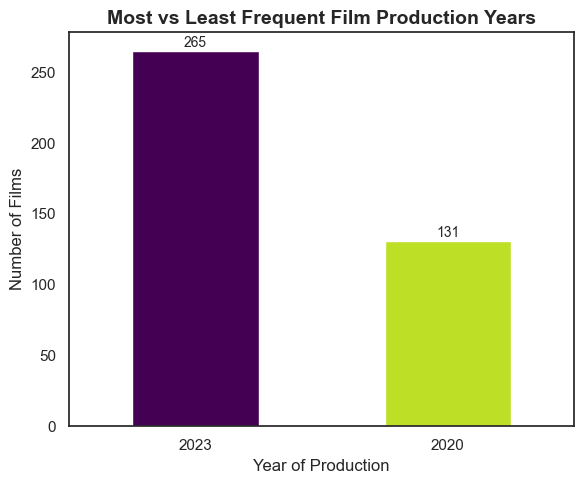

In [21]:
# Get most and least frequent production years
top_production_year = df_fusion['year_of_production'].value_counts().head(1)
least_production_year = df_fusion['year_of_production'].value_counts().nsmallest(2).iloc[1:]

# Combine into one Series for plotting
years_summary = pd.concat([top_production_year, least_production_year])

viridis_colors = [
    '#440154',  # Dark purple
    '#482878',  # Purple
    '#3e4a89',  # Deep blue
    '#31688e',  # Blue
    '#26828e',  # Teal
    '#1f9e89',  # Green-blue
    '#4dbd6e',  # Light green
    '#7ad151',  # Yellow-green
    '#bddf26',  # Yellow
    '#f0f921'   # Bright yellow
]


# Extract colors from the Viridis palette (first and last)
first_color = viridis_colors[0] # First color (darkest)
sixth_color = viridis_colors[-2]  # Sixth color

# Plotting
sns.set_theme(style='white')
plt.figure(figsize=(6, 5))

# Manually set the colors for the bars
ax = years_summary.plot(kind='bar', color=[first_color, sixth_color])

# Title and axis labels
plt.title('Most vs Least Frequent Film Production Years', fontsize=14, fontweight='bold')
plt.xlabel('Year of Production', fontsize=12)
plt.ylabel('Number of Films', fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)

# Remove gridlines
ax.grid(False)

# Annotate bars
for index, value in enumerate(years_summary.values):
    ax.text(index, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


#### What films had the highest/lowest budgets ?

🎬 Film with Max Budget:
             film_title main_genre_jpboxoffice       budget
231  Avengers: Endgame              Comicbook  356000000.0

🎬 Film with Min Budget:
          film_title main_genre_jpboxoffice    budget
323       Le Cercle                  Drame  100000.0
1488  A Ghost Story                  Drame  100000.0


/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_17083/3623526251.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='film_title', y='budget_scaled', data=film_budgets, width=0.5, palette=[viridis_colors[0], viridis_colors[3]])
/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_17083/3623526251.py:28: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='film_title', y='budget_scaled', data=film_budgets, width=0.5, palette=[viridis_colors[0], viridis_colors[3]])


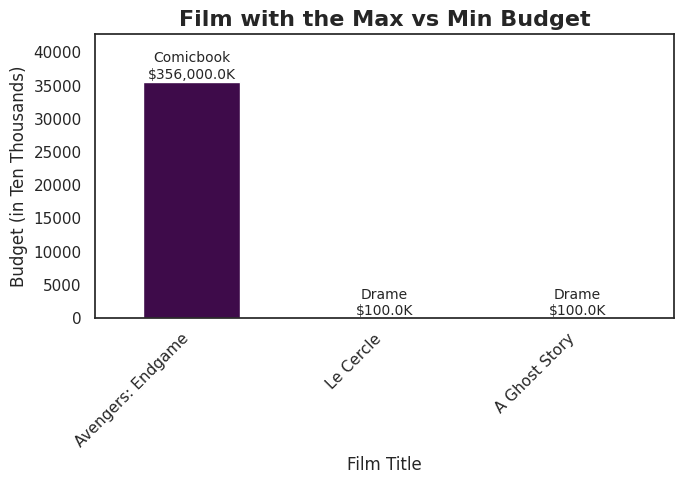

In [22]:
# Film with the overall max budget
film_with_max_budget = df_fusion[df_fusion['budget'] == df_fusion['budget'].max()][['film_title', 'main_genre_jpboxoffice', 'budget']]

# Film with the overall min budget
film_with_min_budget = df_fusion[df_fusion['budget'] == df_fusion['budget'].min()][['film_title', 'main_genre_jpboxoffice', 'budget']]

print("🎬 Film with Max Budget:\n", film_with_max_budget)
print("\n🎬 Film with Min Budget:\n", film_with_min_budget)


# Sample data for the film budgets
film_budgets = pd.DataFrame({
    'film_title': ['Avengers: Endgame', 'Le Cercle', 'A Ghost Story'],
    'main_genre_jpboxoffice': ['Comicbook', 'Drame', 'Drame'],
    'budget': [356000000.0, 100000.0, 100000.0]
})

# Scale the budgets to make them more comparable
film_budgets['budget_scaled'] = film_budgets['budget'] / 10000  # Scale down by 10,000

# Plotting
plt.figure(figsize=(7, 5))

# # Use DejaVu Sans to support emoji if needed
plt.rcParams['font.family'] = 'DejaVu Sans'

# Create a bar plot with viridis palette
sns.barplot(x='film_title', y='budget_scaled', data=film_budgets, width=0.5, palette=[viridis_colors[0], viridis_colors[3]])

# Title and axis labels
plt.title('Film with the Max vs Min Budget', fontsize=16, fontweight='bold')
plt.xlabel('Film Title', fontsize=12)
plt.ylabel('Budget (in Ten Thousands)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

# Adjust y-axis limit to ensure there's space above the bars
plt.ylim(0, film_budgets['budget_scaled'].max() * 1.2)

# Annotate each bar with the genre and budget (in thousands)
for index, row in film_budgets.iterrows():
    # Add a small dynamic offset above each bar for the text
    plt.text(index, row['budget_scaled'] + 0.1, 
             f"{row['main_genre_jpboxoffice']}\n${row['budget'] / 1000:,}K",  # Annotate budget in thousands (K)
             ha='center', va='bottom', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

#### What genres had the highest/lowest budgets ?

💰 Genre with Highest Total Budget: Aventure - Action (21867858000.0)
🪙 Genre with Lowest Total Budget: Court-métrage (14700000.0)


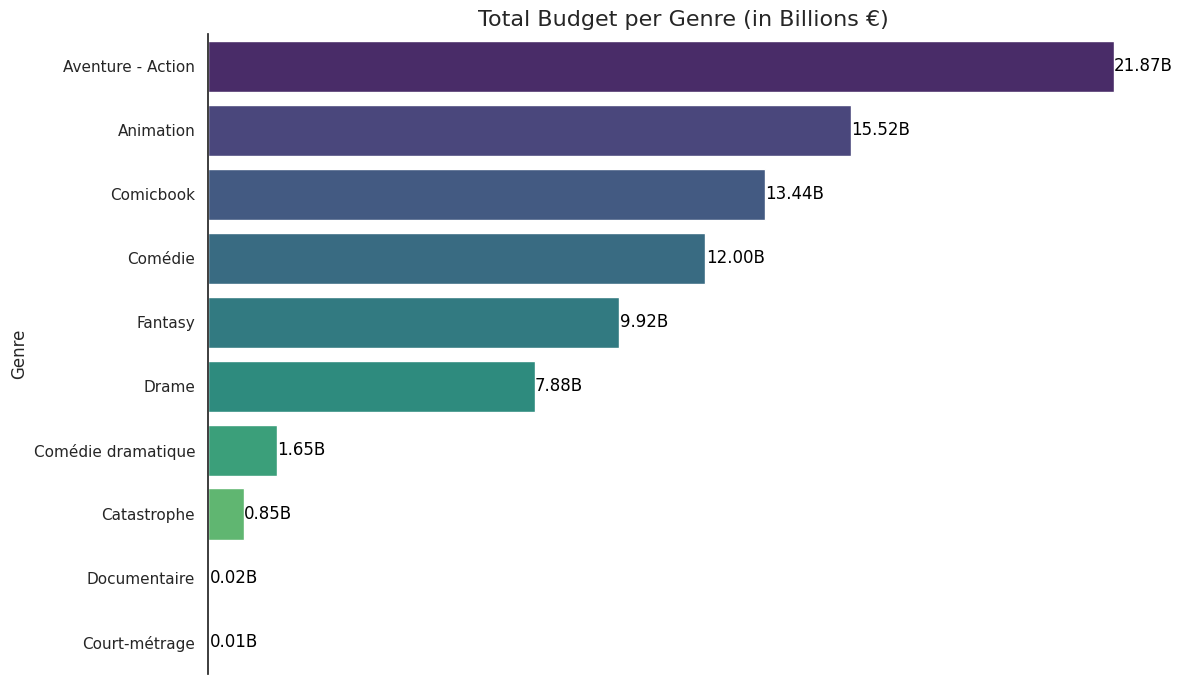

In [23]:
# Total budget per genre
total_budget_per_genre = df_fusion.groupby('main_genre_jpboxoffice')['budget'].sum()

# Genre with the highest total budget
genre_with_highest_total_budget = total_budget_per_genre.idxmax()
highest_total_budget = total_budget_per_genre.max()

# Genre with the lowest total budget
genre_with_lowest_total_budget = total_budget_per_genre.idxmin()
lowest_total_budget = total_budget_per_genre.min()

print(f"💰 Genre with Highest Total Budget: {genre_with_highest_total_budget} ({highest_total_budget})")
print(f"🪙 Genre with Lowest Total Budget: {genre_with_lowest_total_budget} ({lowest_total_budget})")


# Visualize Data

# Prepare the data
total_budget_per_genre_sorted = total_budget_per_genre.sort_values(ascending=False).reset_index()
total_budget_per_genre_sorted.columns = ['Genre', 'Total_Budget']
total_budget_per_genre_sorted['Total_Budget_Billion'] = total_budget_per_genre_sorted['Total_Budget'] / 1e9

# Create the plot
plt.figure(figsize=(12, 7))
barplot = sns.barplot(
    data=total_budget_per_genre_sorted,
    x='Total_Budget_Billion',
    y='Genre',
    palette='viridis', hue='Genre'
)

# Add text labels on bars
for index, row in total_budget_per_genre_sorted.iterrows():
    barplot.text(
        row['Total_Budget_Billion'] + 0.01,
        index,
        f"{row['Total_Budget_Billion']:.2f}B",
        color='black',
        va='center'
    )

# Clean up the x-axis
barplot.set_xlabel('')
barplot.set_xticks([])
barplot.set_xticklabels([])
barplot.tick_params(axis='x', which='both', bottom=False, top=False)

# Optional: remove x-axis line/grid
sns.despine(left=False, bottom=True)

# Final touch
plt.title('Total Budget per Genre (in Billions €)', fontsize=16)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

#### What month was the most(or least) films released in France ?

📈 Most films were released in: August (179 films)
📉 Least films were released in: February (142 films)


/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_17083/2270331040.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=month_counts.index, x=month_counts.values, palette='viridis')


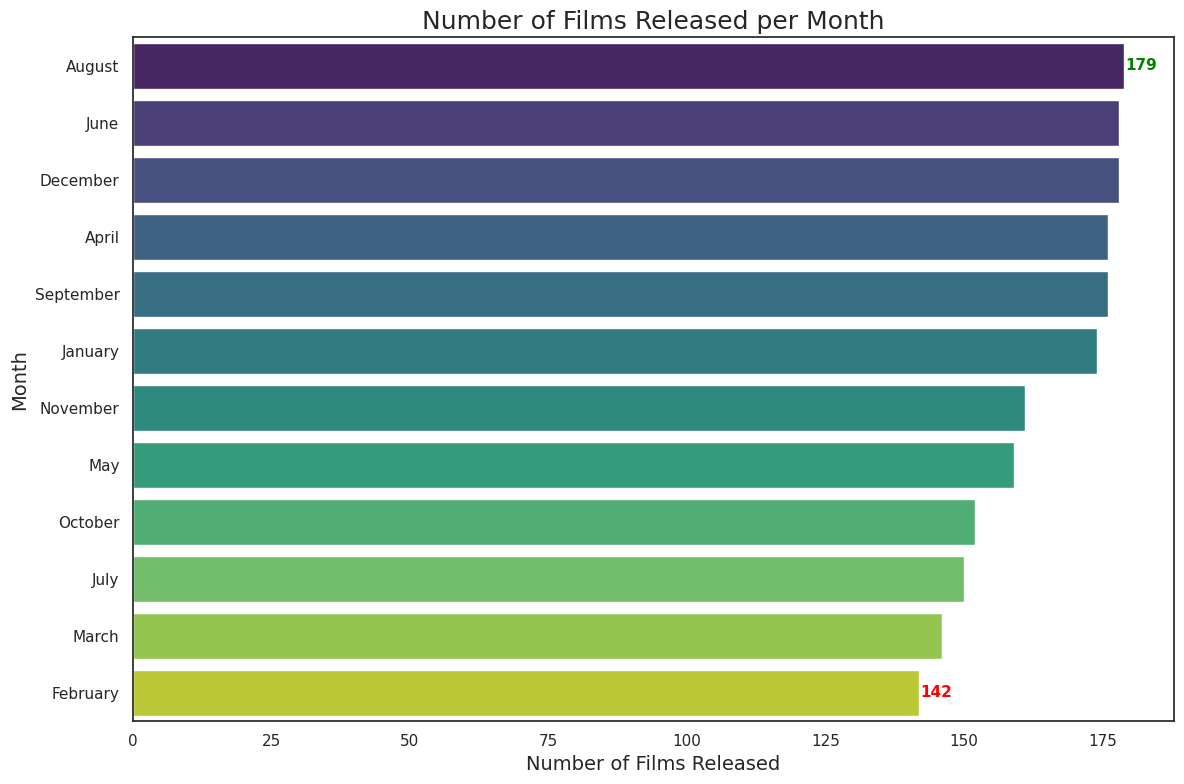

In [24]:
# Convert the release_date column to datetime format (day/month/year)
df_fusion.loc[:, 'release_date_france'] = pd.to_datetime(df_fusion['release_date_france'], format='%d-%m-%Y', errors='coerce')

# Extract the month name from the datetime
df_fusion.loc[:, 'release_month'] = df_fusion['release_date_france'].dt.month_name()

# Count number of films released per month
month_counts = df_fusion['release_month'].value_counts()

# # Get the month with the most and least releases
most_common_month = month_counts.idxmax()
most_common_count = month_counts.max()

least_common_month = month_counts.idxmin()
least_common_count = month_counts.min()

# Print results
print(f"📈 Most films were released in: {most_common_month} ({most_common_count} films)")
print(f"📉 Least films were released in: {least_common_month} ({least_common_count} films)")


## Create plot

# Define custom order for months from January to December
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Get the count of films released per month and ensure the months are ordered
month_counts = df_fusion['release_month'].value_counts().reindex(month_order).fillna(0).sort_values(ascending=False)

# Create a bar plot with months on the Y-axis
plt.figure(figsize=(12, 8))
sns.barplot(y=month_counts.index, x=month_counts.values, palette='viridis')

# Add titles and labels
plt.title('Number of Films Released per Month', fontsize=18)
plt.ylabel('Month', fontsize=14)
plt.xlabel('Number of Films Released', fontsize=14)

# Annotate the months with the most and least releases
plt.text(most_common_count + 0.2, most_common_month, f'{most_common_count}', 
         ha='left', va='center', fontsize=11, color='green', fontweight='bold')
plt.text(least_common_count + 0.2, least_common_month, f'{least_common_count}', 
         ha='left', va='center', fontsize=11, color='red', fontweight='bold')

# Show the plot with a tight layout
plt.tight_layout()
plt.show()


In [25]:
df_fusion.isna().sum()

film_id                                0
film_title                             0
image_url                              0
year_of_production                     0
release_date_france                 3009
release_date_usa                    2460
nationality                         3467
languages                              0
duration                               9
age_classification                  4408
director                               6
top_stars                             72
producers                              6
main_genre_jpboxoffice                 0
associated_genres_allocine             0
synopsis                               3
filming_secrets                        0
awards                              2903
broadcast_category                     0
distributor                          150
budget                              3492
fr_entries                             0
fr_entries_cumul                       0
fr_entry_week                        602
us_entries      

#### What season was the most (or least) films produced ?

+----------------+--------------------------+
| Release Season | Number of Films Released |
+----------------+--------------------------+
|     Autumn     |           1335           |
|     Winter     |           1318           |
|     Spring     |           1212           |
|     Summer     |           1115           |
+----------------+--------------------------+


/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_17083/1227831261.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=release_season_counts.values, y=release_season_counts.index, palette='viridis', width=0.6)


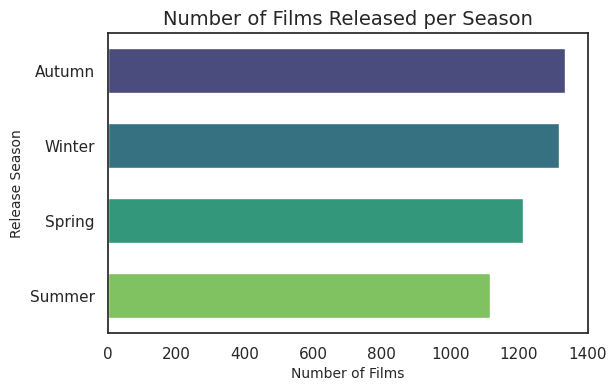

In [26]:
# Get the count of films per release season
release_season_counts = df_fusion['release_season'].value_counts().sort_values(ascending=False)

# Create a PrettyTable instance
table = PrettyTable()

# Define the column names
table.field_names = ["Release Season", "Number of Films Released"]

# Add the data to the table
for season, count in release_season_counts.items():
    table.add_row([season, count])

# Print the table
print(table)


# Create the bar plot with release seasons on the y-axis
plt.figure(figsize=(8, 6))  # Adjust the figure size to avoid large bars
sns.barplot(x=release_season_counts.values, y=release_season_counts.index, palette='viridis', width=0.6)

# Add titles and labels
plt.title('Number of Films Released per Season', fontsize=14)
plt.xlabel('Number of Films', fontsize=10)
plt.ylabel('Release Season', fontsize=10)

# Adjust spacing to reduce gap between labels
plt.tight_layout()  # Ensures the layout is adjusted
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.4)  # Reduce space around the plot

# Show plot
plt.show()


In [27]:
# Funtion to calculate multiple statistics

def multi_stats(df):  # sourcery skip: extract-method, merge-comparisons
    # Top Genres
    top_genres = df['main_genre_jpboxoffice'].value_counts().head(10).reset_index()
    top_genres.columns = ['Genre', 'Count']
    
    # Top actors
    if 'top_stars_list' in df.columns:
        actors_series = df['top_stars_list'].dropna()
        exploded_actors = actors_series.explode()
        top_actors = exploded_actors.value_counts().head(10).to_frame(name='Appearances')
        top_actors.index.name = 'Actor'
        top_actors.reset_index(inplace=True)
        # Remove rows where Actor is an empty list or empty string
        top_actors = top_actors[top_actors['Actor'].apply(lambda x: x != "[]" and x != '')]
    else:
        top_actors = pd.DataFrame(columns=['Actor', 'Appearances'])

    # Average Movie Duration Per Year
    avg_movie_dur = (
        df.groupby('year_of_production')['duration_minutes']
        .mean()
        .reset_index()
        .sort_values(by='year_of_production')
    )
    avg_movie_dur.columns = ['Year', 'Average_Duration_Minutes']

    return top_genres, top_actors, avg_movie_dur

top_genres, top_actors, avg_movie_dur = multi_stats(df_fusion)

#### What genres had the highest number of films ?

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_17083/2995725467.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_genres, x='Count', y='Genre', palette='viridis')


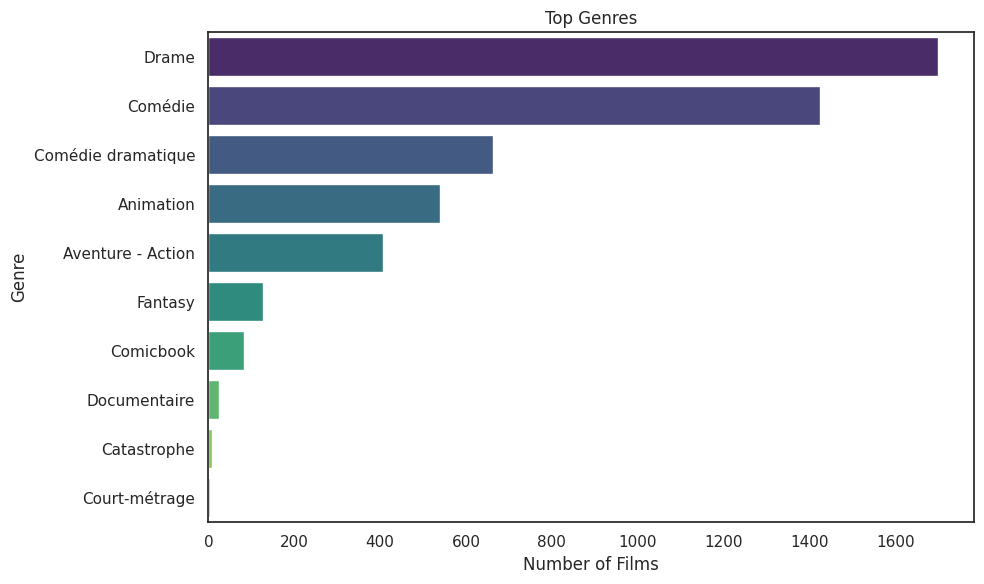

In [28]:
# Plot for Top Genres
plt.figure(figsize=(10, 6))
sns.barplot(data=top_genres, x='Count', y='Genre', palette='viridis')
plt.title('Top Genres')
plt.xlabel('Number of Films')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

#### Which top actors have featured in the most films ?

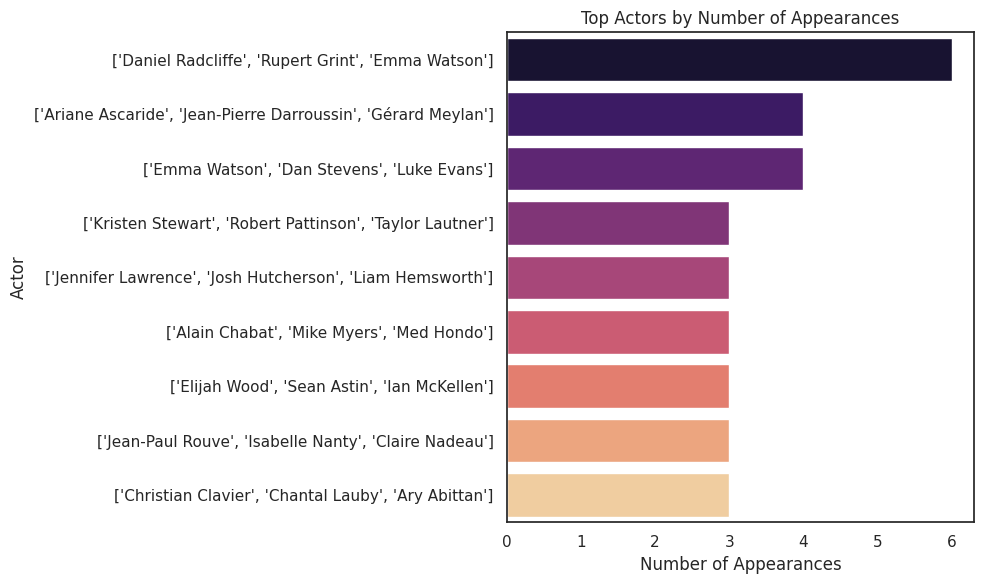

In [29]:
# Plot for Top Actors (if data available)
if not top_actors.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_actors, x='Appearances', y='Actor', palette='magma', hue='Actor')
    plt.title('Top Actors by Number of Appearances')
    plt.xlabel('Number of Appearances')
    plt.ylabel('Actor')
    plt.tight_layout()
    plt.show()
else:
    print("No actor data to display.")


#### What is the average duration (in minutes) per films ?

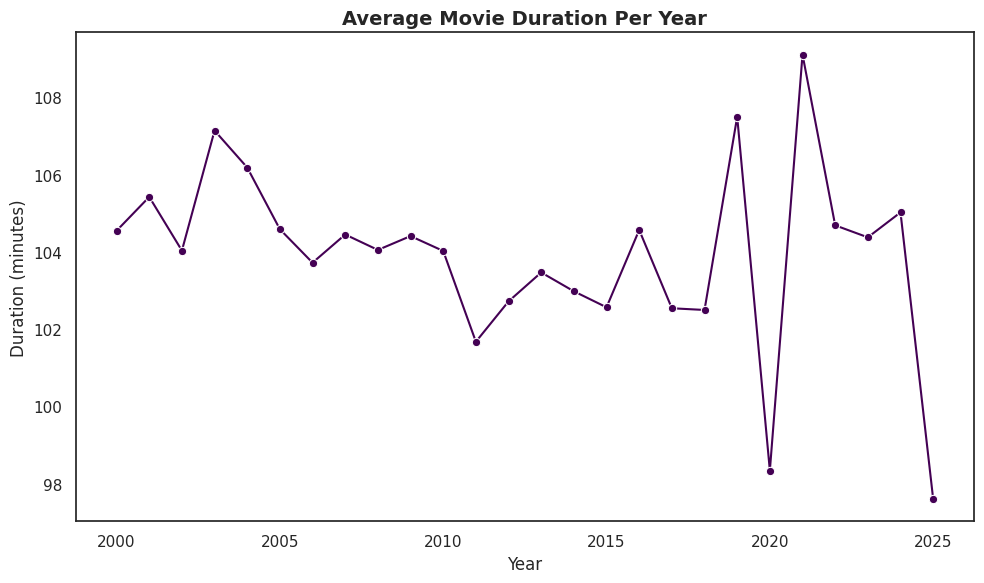

In [30]:
# Plot for Average Movie Duration per Year
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_movie_dur, x='Year', y='Average_Duration_Minutes', marker='o', color=viridis_colors[0])
plt.title('Average Movie Duration Per Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.tight_layout()
plt.show()

#### What is distribution of the duration (in minutes) of films ?

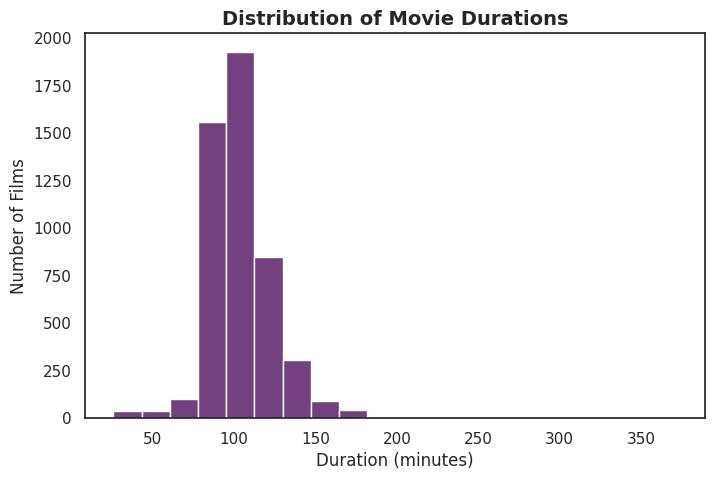

In [31]:
plt.figure(figsize=(8,5))
sns.histplot(df_fusion['duration_minutes'].dropna(), bins=20,color=viridis_colors[0])
plt.title('Distribution of Movie Durations', fontsize=14, fontweight='bold')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Films')
plt.show()

In [32]:
df_fusion.columns

Index(['film_id', 'film_title', 'image_url', 'year_of_production',
       'release_date_france', 'release_date_usa', 'nationality', 'languages',
       'duration', 'age_classification', 'director', 'top_stars', 'producers',
       'main_genre_jpboxoffice', 'associated_genres_allocine', 'synopsis',
       'filming_secrets', 'awards', 'broadcast_category', 'distributor',
       'budget', 'fr_entries', 'fr_entries_cumul', 'fr_entry_week',
       'us_entries', 'us_entry_week', 'revenue_usa', 'revenue_world',
       'press_rating', 'viewer_rating', 'press_critics_count',
       'viewer_critics_count', 'trailer_views', 'release_season',
       'duration_minutes', 'producers_list', 'producers_count',
       'top_stars_list', 'top_stars_count', 'languages_list',
       'languages_count', 'nationality_list', 'nationality_list_count',
       'associated_genres_allocine_list', 'associated_genres_allocine_count',
       'fr_entry_week_iso_week', 'us_entry_week_iso_week',
       'filming_secrets_nu

#### Top 10 actor trios with the average global revenue

In [33]:
def actor_success_1(df):
    exploded = df[['top_stars_list', 'revenue_world']].explode('top_stars_list')
    actor_rev = exploded.groupby('top_stars_list')['revenue_world'].mean().sort_values(ascending=False)
    
    print("\n--- Top Revenue-Generating Actors ---")
    actors_suc = actor_rev.head(10).reset_index()
    actors_suc.columns = ['Actor', 'Average_Revenue_World']
    
    return actors_suc


--- Top Revenue-Generating Actors ---
                                               Actor  Average_Revenue_World
0  ['Robert Downey Jr.', 'Chris Evans', 'Mark Ruf...           1.939428e+09
1  ['Robert Downey Jr.', 'Chris Hemsworth', 'Mark...           1.369896e+09
2     ['Vin Diesel', 'Paul Walker', 'Jason Statham']           1.163039e+09
3     ['Daisy Ridley', 'John Boyega', 'Adam Driver']           1.131561e+09
4  ['Rayane Bensetti', 'Donald Glover', 'Anne Sila']           1.113305e+09
5  ['Charlotte Le Bon', 'Amy Poehler', 'Jaynelia ...           1.023200e+09
6  ['Chris Pratt', 'Bryce Dallas Howard', 'Nick R...           1.019443e+09
7  ['Vin Diesel', 'Dwayne Johnson', 'Jason Statham']           1.009997e+09
8  ['Chris Pratt', 'Bryce Dallas Howard', 'Rafe S...           8.917647e+08
9    ['Emmylou Homs', 'Kristen Bell', 'Anaïs Delva']           8.757423e+08


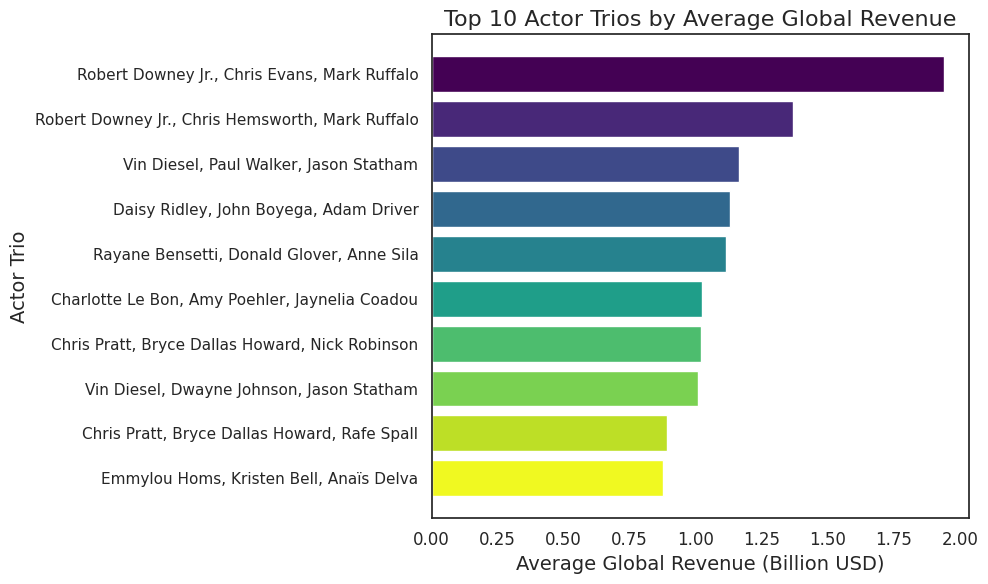

In [34]:
def plot_actor_trio_success(actor_rev_df):
    # Convert stringified lists to actual lists
    actor_rev_df['Actor_Label'] = actor_rev_df['Actor'].apply(
        lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else str(x)
    )

    # Convert revenue to billions
    actor_rev_df['Revenue_Billion'] = actor_rev_df['Average_Revenue_World'] / 1e9

    # Sort by revenue for barh plot
    plot_df = actor_rev_df.sort_values(by='Revenue_Billion', ascending=True)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(
        plot_df['Actor_Label'],
        plot_df['Revenue_Billion'],
        color=viridis_colors[::-1]
    )
    plt.title('Top 10 Actor Trios by Average Global Revenue', fontsize=16)
    plt.xlabel('Average Global Revenue (Billion USD)', fontsize=14)
    plt.ylabel('Actor Trio', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()


actor_rev_df = actor_success_1(df_fusion)
print(actor_rev_df)
plot_actor_trio_success(actor_rev_df)


#### Top 10 genres by total award count

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_17083/3682871987.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_awards.values, y=genre_awards.index, palette='viridis')


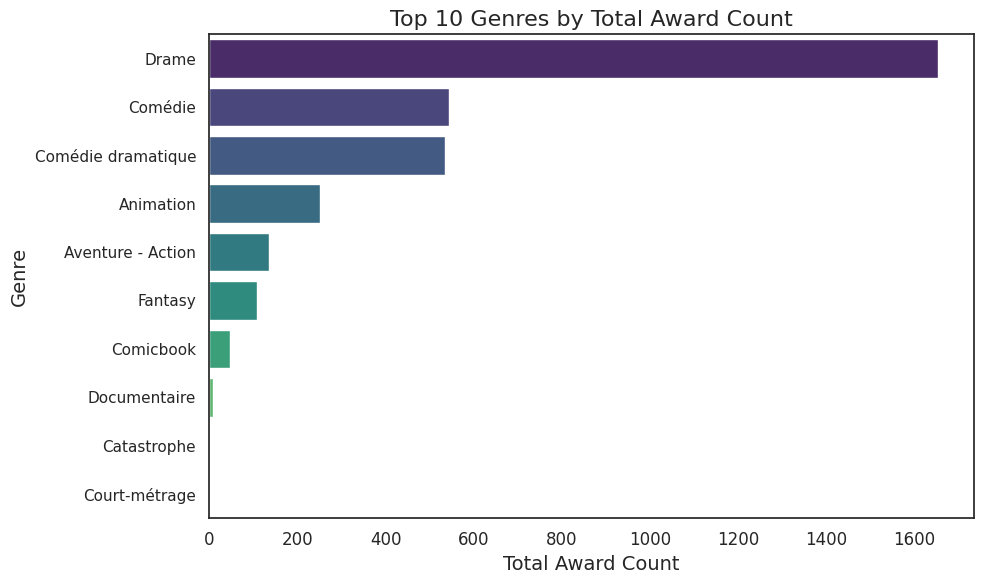

In [35]:
def plot_genre_awards(df):
    # Handle multiple genres per movie
    exploded = df[['main_genre_jpboxoffice', 'award_count']].copy()
    exploded['main_genre_jpboxoffice'] = exploded['main_genre_jpboxoffice'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
    exploded = exploded.explode('main_genre_jpboxoffice')

    # Group by genre and sum awards
    genre_awards = exploded.groupby('main_genre_jpboxoffice')['award_count'].sum().sort_values(ascending=False).head(10)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=genre_awards.values, y=genre_awards.index, palette='viridis')
    plt.title('Top 10 Genres by Total Award Count', fontsize=16)
    plt.xlabel('Total Award Count', fontsize=14)
    plt.ylabel('Genre', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

plot_genre_awards(df_fusion)

#### Time-series analysis of budget vs global revenue

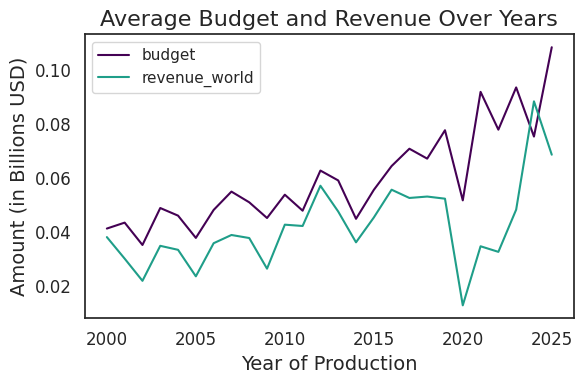

In [36]:
def trend_budget_revenue(df):
    # Group by year and calculate mean
    yearly = df.groupby('year_of_production')[['budget', 'revenue_world']].mean()

    # Convert to billions
    yearly_billion = yearly / 1e9

    # Plot
    plt.figure(figsize=(6, 4))
    yearly_billion.plot(ax=plt.gca(), color=[viridis_colors[0], viridis_colors[5]])
    plt.title("Average Budget and Revenue Over Years", fontsize=16)
    plt.ylabel('Amount (in Billions USD)', fontsize=14)
    plt.xlabel('Year of Production', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

trend_budget_revenue(df_fusion)

#### Text analysis of synopsis (word cloud)

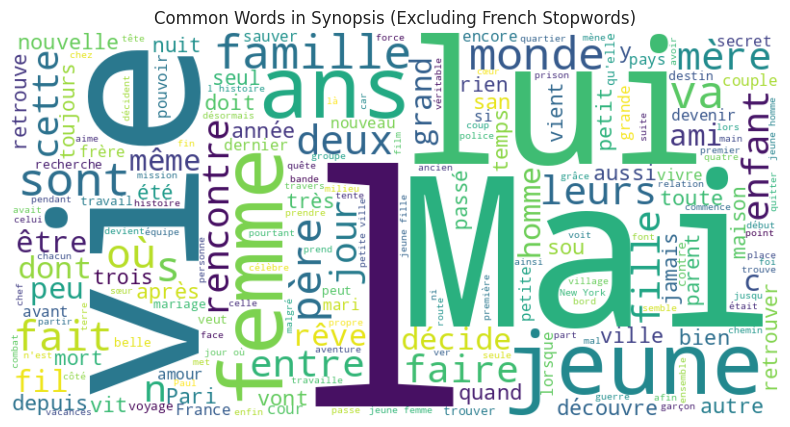

In [37]:
def generate_wordcloud(df):
    # Define French stopwords (you can expand this list if needed)
    french_stopwords = {
        'd',
        'alors',
        'et',
        'est',
        'd\'une',
        'd\'un',
        'la',
        'le',
        'les',
        'des',
        'du',
        'de',
        'un',
        'une',
        'en',
        'dans',
        'que',
        'qui',
        'pour',
        'sur',
        'par',
        'au',
        'aux',
        'ce',
        'ces',
        'son',
        'sa',
        'ses',
        'ne',
        'pas',
        'ou',
        '1',
        'qu',
        'qu\'il',
        'ont',
        'c\'est',
        'plus',
        'avec',
        'il',
        'elle',
        'ils',
        'leur',
        'tout',
        'tous',
        'elles',
        'nous',
        'vous',
        'se',
        'comme',
        'a',
        'à',
        'n\'a',
    }

    # Combine with default stopwords
    custom_stopwords = STOPWORDS.union(french_stopwords)

    text = ' '.join(df['synopsis'].dropna().astype(str).tolist())
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Common Words in Synopsis (Excluding French Stopwords)")
    plt.show()



generate_wordcloud(df_fusion)

#### Sentiment Analysis of Synopsis

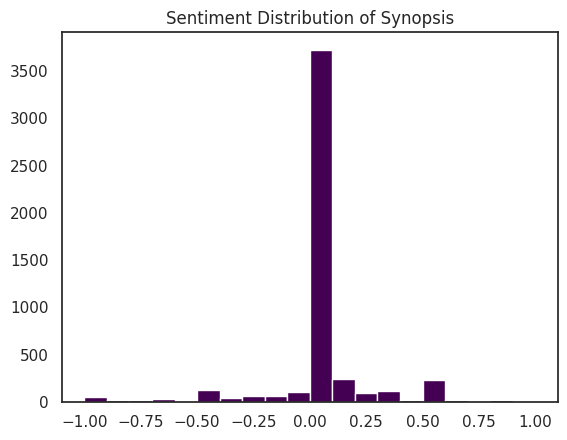

In [38]:
def sentiment_synopsis(df):
    df['synopsis_sentiment'] = df['synopsis'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    plt.hist(df['synopsis_sentiment'], bins=20, color=viridis_colors[0])
    plt.title("Sentiment Distribution of Synopsis")
    plt.show()

sentiment_synopsis(df_fusion)

## Multivariate Analysis (France) 

### 🎯 Analysis Business Objective : What factors influence a strong film opening attendance in France?

### 🔍 Audience & Content Fit

#### 🎥 Which genres perform best in opening week? (JpBoxOffice)

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_17083/987282637.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_perf.values, y=genre_perf.index, palette='viridis')


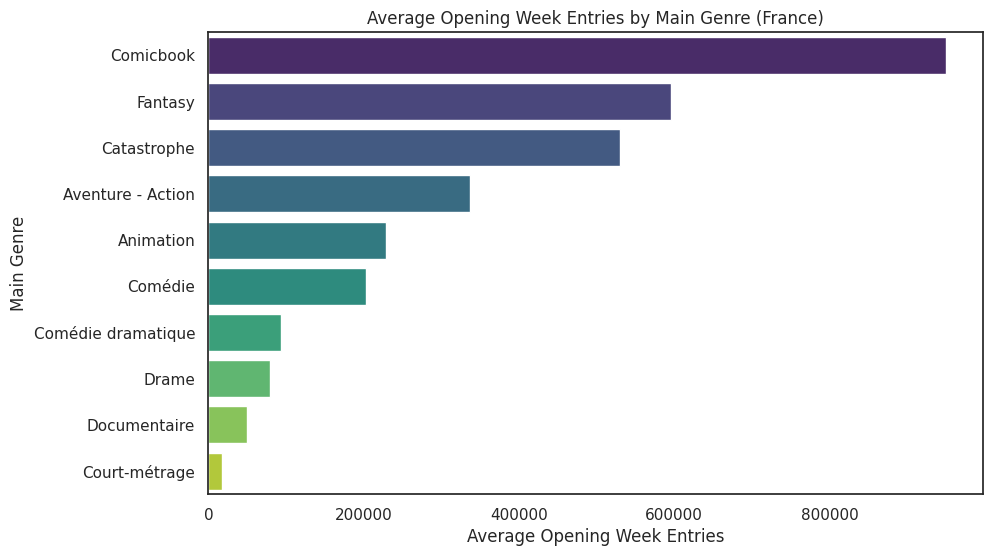

In [39]:
# Group by main genre and calculate average first-week entries
genre_perf = df_fusion.groupby('main_genre_jpboxoffice')['opening_week_france_num'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=genre_perf.values, y=genre_perf.index, palette='viridis')
plt.title('Average Opening Week Entries by Main Genre (France)')
plt.xlabel('Average Opening Week Entries')
plt.ylabel('Main Genre')
plt.show()

#### 🎬 Which film genres attract the largest audiences during opening week in France (Allocine) ?

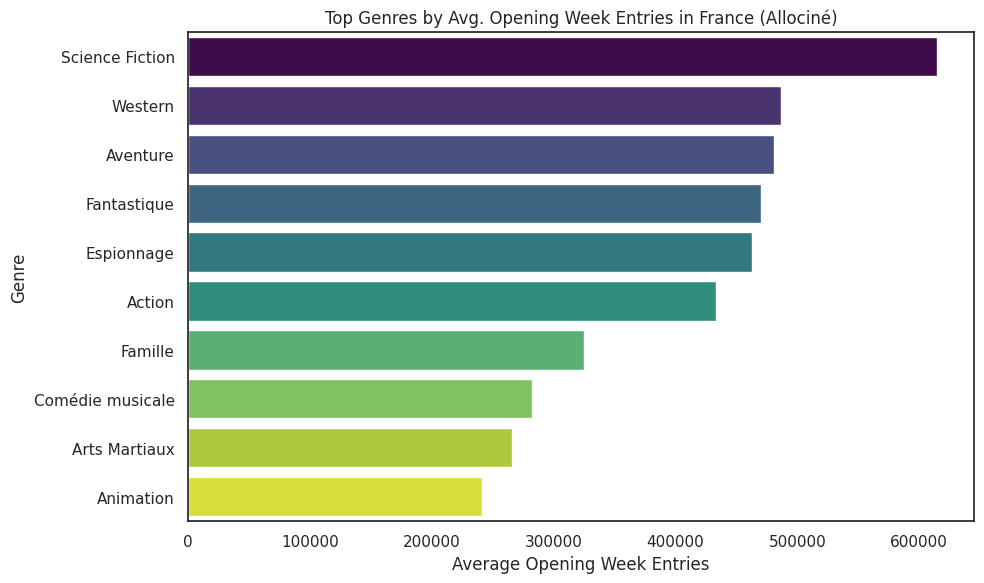

In [85]:
# Convert strings to actual lists if not already
import ast

df_fusion['associated_genres_allocine_list'] = df_fusion['associated_genres_allocine_list'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
)

# Explode the genre list
df_exploded_genres = df_fusion.explode('associated_genres_allocine_list')

# Group and analyze
genre_perf = (
    df_exploded_genres
    .groupby('associated_genres_allocine_list')['opening_week_france_num']
    .agg(['count', 'mean'])
    .reset_index()
    .rename(columns={
        'associated_genres_allocine_list': 'Genre',
        'count': 'Number of Films',
        'mean': 'Average Opening Week Entries'
    })
    .sort_values(by='Average Opening Week Entries', ascending=False)
)

# Plot top 10 performing genres by average opening week entries
plt.figure(figsize=(10, 6))
sns.barplot(
    data=genre_perf.head(10),
    x='Average Opening Week Entries',
    y='Genre',
    palette=viridis_colors,
    hue='Genre',
    legend=False
)
plt.title('Top Genres by Avg. Opening Week Entries in France (Allociné)')
plt.xlabel('Average Opening Week Entries')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

#### 🇫🇷 Do films produced in France or in collaboration with France outperform international ones?

In [59]:
import ast
import contextlib

def safe_parse_list(x):
    with contextlib.suppress(Exception):
        if isinstance(x, str) and x.startswith('['):
            return ast.literal_eval(x)
    return []

# Fix nationality_list
df_fusion['nationality_list'] = df_fusion['nationality_list'].apply(safe_parse_list)

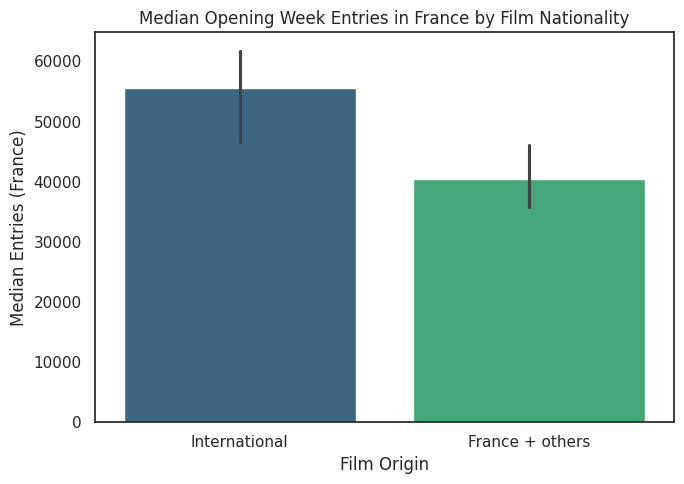

In [77]:
# Filter out empty nationality lists
df_nationality = df_fusion[df_fusion['nationality_list'].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()

# Categorize films
def categorize_film(nat_list):
    if nat_list == ['France']:
        return 'France only'
    elif 'France' in nat_list:
        return 'France + others'
    else:
        return 'International'

df_nationality['film_origin'] = df_nationality['nationality_list'].apply(categorize_film)

# Filter rows with opening week data
df_plot = df_nationality.dropna(subset=['opening_week_france_num'])

plt.figure(figsize=(7, 5))
sns.barplot(data=df_plot, x='film_origin', y='opening_week_france_num', estimator='median', palette='viridis', hue='film_origin', legend=False)
plt.title('Median Opening Week Entries in France by Film Nationality')
plt.ylabel('Median Entries (France)')
plt.xlabel('Film Origin')
plt.tight_layout()
plt.show()

In [82]:
genre_perf

,count,mean
associated_genres_allocine_list,,
Science Fiction,127,614261.385827
Western,7,486507.857143
Aventure,472,481183.661017
Fantastique,306,470323.444444
Espionnage,32,462933.093750
Action,536,433553.932836
Famille,319,324881.181818
Comédie musicale,29,281939.379310
Arts Martiaux,30,266168.000000


### 🎬 Film Characteristics

#### 🍿 Do shorter or longer movies have better first-week success?

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_17083/4205047074.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_fusion, x='duration_minutes', y='opening_week_france_num', palette=viridis_colors)


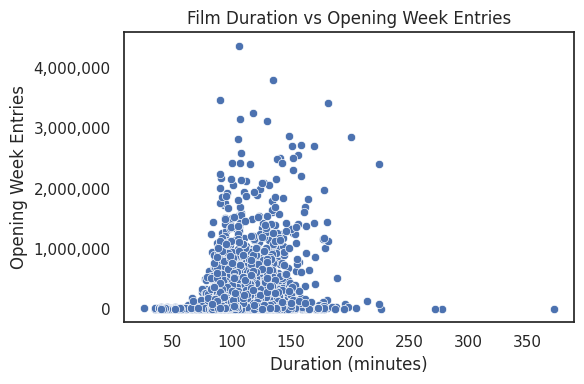

In [92]:
plt.figure(figsize=(6, 4))

sns.scatterplot(data=df_fusion, x='duration_minutes', y='opening_week_france_num', palette=viridis_colors)

plt.title('Film Duration vs Opening Week Entries')
plt.xlabel('Duration (minutes)')
plt.ylabel('Opening Week Entries')

# Format y-axis to show plain numbers (e.g., 500000 instead of 5e5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

#### 🚸 Do PG, General, or R-rated films tend to get better openings?

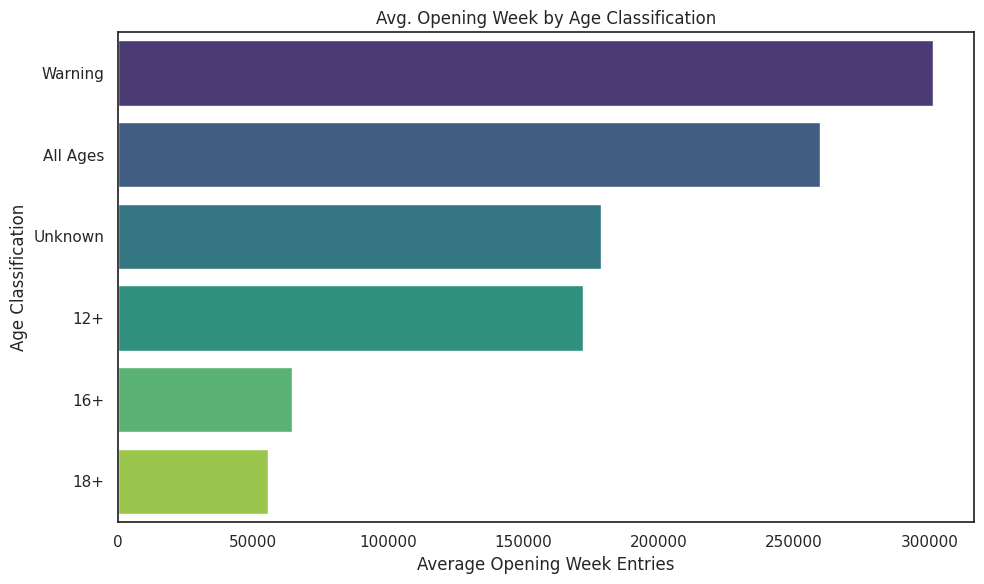

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cleaned/Grouped version for clarity
def simplify_age_classification(age):
    if pd.isnull(age):
        return 'Unknown'
    if '18' in age:
        return '18+'
    elif '16' in age:
        return '16+'
    elif '12' in age:
        return '12+'
    elif 'avertissement' in age.lower():
        return 'Warning'
    elif 'Tout public' in age:
        return 'All Ages'
    else:
        return 'Other'

# Apply simplification
df_fusion['age_class_grouped'] = df_fusion['age_classification'].apply(simplify_age_classification)

# Question 1: Compare average opening for PG vs R-rated-like categories
age_perf = df_fusion.groupby('age_class_grouped')['opening_week_france_num'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

# Question 2: Plot which age categories dominate top openings
plt.figure(figsize=(10, 6))
sns.barplot(
    data=age_perf.reset_index(), 
    x='mean', 
    y='age_class_grouped', 
    palette='viridis', 
    hue='age_class_grouped',
    legend=False
)
plt.title('Avg. Opening Week by Age Classification')
plt.xlabel('Average Opening Week Entries')
plt.ylabel('Age Classification')
plt.tight_layout()
plt.show()

#### ❄️☃️ How does the release season affect opening_week_france_num?

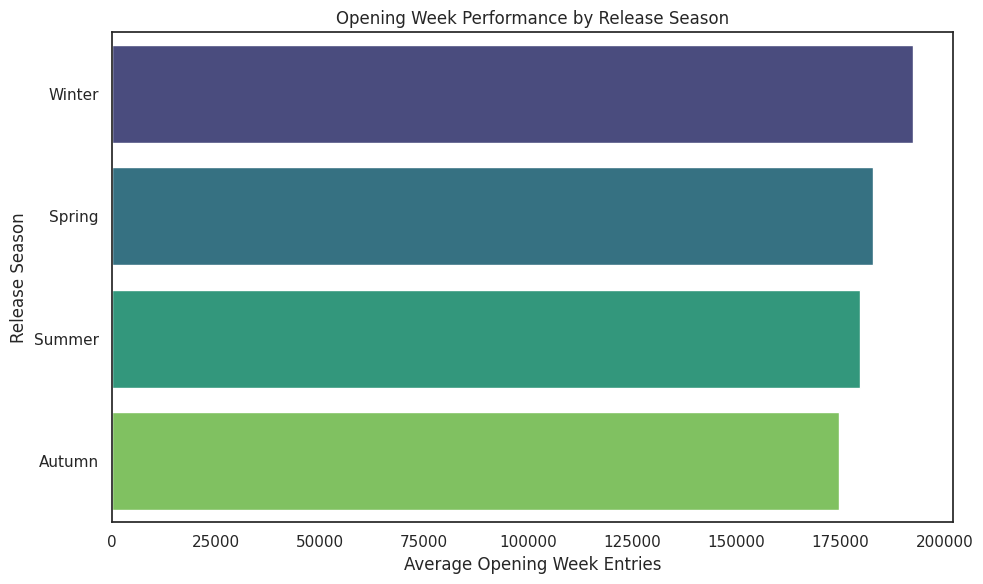

In [142]:
# Group by season and calculate mean opening week performance
season_perf = df_fusion.groupby('release_season')['opening_week_france_num'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

# Plot the seasons' average opening week performance
plt.figure(figsize=(10, 6))
sns.barplot(data=season_perf.reset_index(), 
            x='mean',  # Access 'mean' column here
            y='release_season', 
            palette='viridis', hue='release_season', legend=False)
plt.title('Opening Week Performance by Release Season')
plt.xlabel('Average Opening Week Entries')
plt.ylabel('Release Season')
plt.tight_layout()
plt.show()

#### 📅 Are certain months consistently better for film debuts?

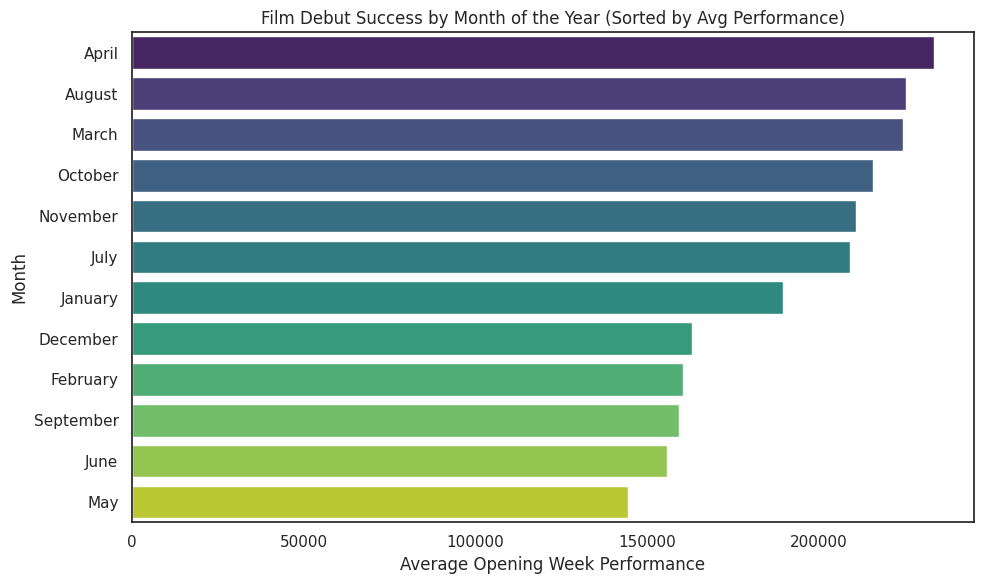

In [ ]:
# Map month numbers to actual month names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Replace month numbers with month names in the DataFrame
df_fusion['month_name'] = df_fusion['fr_entry_month'].map(month_names)

# Calculate mean performance per month
monthly_performance = df_fusion.groupby('month_name')['opening_week_france_num'].mean()

# Sort by performance (descending) to get most successful debut months on top
monthly_performance = monthly_performance.sort_values(ascending=False)

# Convert to DataFrame for Seaborn
plot_data = pd.DataFrame({
    'Month': monthly_performance.index,
    'Average Performance': monthly_performance.values
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Performance', y='Month', data=plot_data, palette='viridis', hue='Month', legend=False)

plt.title('Film Debut Success by Month of the Year (Sorted by Avg Performance)')
plt.xlabel('Average Opening Week Performance')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

In [131]:
monthly_count

month_name
April         273
August        245
December     1737
February      299
January       352
July          335
June          202
March         251
May           371
November      344
October       314
September     257
Name: fr_entry_week_iso_week, dtype: int64

In [129]:
monthly_performance

month_name
April        233354.241758
August       225177.240816
December     162942.807714
February     160291.133779
January      189469.477273
July         208947.704478
June         155822.757426
March        224510.458167
May          144347.283019
November     210767.520349
October      215579.799363
September    159315.797665
Name: opening_week_france_num, dtype: float64

In [130]:
sorted_months

Index(['December', 'May', 'January', 'November', 'July', 'October', 'February',
       'April', 'September', 'March', 'August', 'June'],
      dtype='object', name='month_name')

### 🧑‍🤝‍🧑 Cast, Crew, & Star Power

6. Star Influence
Does the number of top stars (top_stars_count) or specific actors lead to higher opening week numbers?

Which stars or combinations consistently result in stronger French openings?

7. Director & Producer Impact
Do certain directors or producers have a higher average opening_week_france_num?

Does having multiple producers (producers_count) correlate with better openings?

### 📣 Marketing & Hype

8. Trailer Views & Awareness
Do higher trailer views (trailer_views_num) translate to better first-week attendance?

Is there a threshold of trailer views that significantly boosts performance?

9. Buzz & Critic Influence
Does press rating or viewer rating correlate with higher opening_week_france_num?

What’s the impact of early press or viewer critique counts?

### 🏆 Prestige & Recognition

10. Awards & Nominations
Do films with awards or nominations perform better during opening week?

Does pre-release prestige (awards/film festivals) matter?

### 💰 Budget & Revenue

. Does Budget Correlate with Success?
Is there a minimum viable budget range for success in France?

Do high-budget films always do well on opening week or are there diminishing returns?

### 📅 Release Strategy

. USA vs. France Release Timing
Does releasing earlier in the USA (release_date_usa) or simultaneously affect first-week performance in France?

How do French-only first releases perform?

### 📝 Text Analysis Opportunities

13. Synopsis Sentiment
Does positive sentiment in the synopsis (via synopsis_sentiment) correlate with more entries?

Are longer synopses (synopsis_length) a proxy for more complex stories, and do they affect first-week numbers?

14. Filming Secrets & Curiosity
Does the presence of "filming secrets" content (filming_secrets_num) reflect marketing hype that drives openings?



### 🔁 Engagement & Longevity

15. Opening vs. Cumulative Success
Is there a correlation between opening_week_france_num and eventual fr_entries_cumul?

Can you build a predictive model using early indicators?

In [45]:
def genre_performance(df):
    genre_perf = (
        df.groupby('main_genre_jpboxoffice')[['opening_week_france_num', 'viewer_rating']]
        .mean()
        .sort_values(by='opening_week_france_num', ascending=False)
        .reset_index()
    )
    return genre_perf

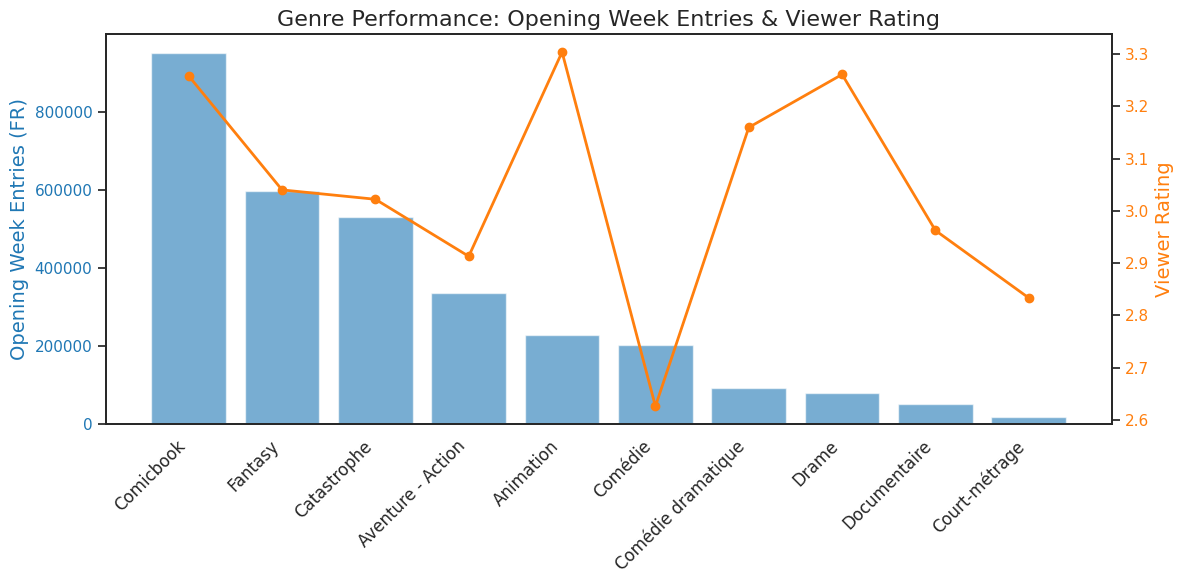

In [46]:
def plot_genre_performance_dual_axis(genre_perf_df):
    df_sorted = genre_perf_df.sort_values(by='opening_week_france_num', ascending=False)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    genres = df_sorted['main_genre_jpboxoffice']
    x = np.arange(len(genres))

    color1 = 'tab:blue'
    ax1.bar(x, df_sorted['opening_week_france_num'], color=color1, alpha=0.6, label='Opening Week Entries')
    ax1.set_ylabel('Opening Week Entries (FR)', color=color1, fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(genres, rotation=45, ha='right', fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.plot(x, df_sorted['viewer_rating'], color=color2, marker='o', linewidth=2, label='Viewer Rating')
    ax2.set_ylabel('Viewer Rating', color=color2, fontsize=14)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title('Genre Performance: Opening Week Entries & Viewer Rating', fontsize=16)
    fig.tight_layout()
    plt.show()


genre_perf_df = genre_performance(df_fusion)
plot_genre_performance_dual_axis(genre_perf_df)

In [47]:
df_fusion.columns

Index(['film_id', 'film_title', 'image_url', 'year_of_production',
       'release_date_france', 'release_date_usa', 'nationality', 'languages',
       'duration', 'age_classification', 'director', 'top_stars', 'producers',
       'main_genre_jpboxoffice', 'associated_genres_allocine', 'synopsis',
       'filming_secrets', 'awards', 'broadcast_category', 'distributor',
       'budget', 'fr_entries', 'fr_entries_cumul', 'fr_entry_week',
       'us_entries', 'us_entry_week', 'revenue_usa', 'revenue_world',
       'press_rating', 'viewer_rating', 'press_critics_count',
       'viewer_critics_count', 'trailer_views', 'release_season',
       'duration_minutes', 'producers_list', 'producers_count',
       'top_stars_list', 'top_stars_count', 'languages_list',
       'languages_count', 'nationality_list', 'nationality_list_count',
       'associated_genres_allocine_list', 'associated_genres_allocine_count',
       'fr_entry_week_iso_week', 'us_entry_week_iso_week',
       'filming_secrets_nu

#### Correlation Analysis

In [48]:
# def correlation_matrix(df):
#     numeric_cols = df.select_dtypes(include=np.number)
#     corr = numeric_cols.corr()
#     plt.figure(figsize=(20, 12))
#     sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
#     plt.title("Correlation Heatmap")
#     plt.show()

# correlation_matrix(df_fusion)

#### View distribution of entries in France

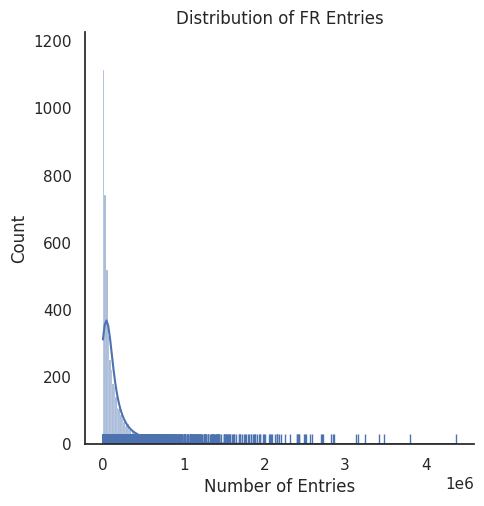

In [49]:
sns.displot(df_fusion['opening_week_france_num'], kde=True, rug=True)
plt.title('Distribution of FR Entries')
plt.xlabel('Number of Entries')
plt.show()

### 

In [50]:
# df_analysis = df_fusion[['opening_week_france_num', 'film_id', 'year_of_production',
#        'release_date_france', 'release_date_usa', 'age_classification', 'director',
#        'main_genre_jpboxoffice', 'associated_genres_allocine', 'synopsis',
#        'broadcast_category', 'distributor', 'budget', 'revenue_usa', 'revenue_world',
#        'press_rating', 'viewer_rating', 'release_season',
#        'duration_minutes', 'producers_list', 'producers_count',
#        'top_stars_list', 'top_stars_count', 'languages_list',
#        'languages_count', 'nationality_list', 'nationality_list_count',
#        'associated_genres_allocine_list', 'associated_genres_allocine_count',
#        'fr_entry_week_iso_week', 'us_entry_week_iso_week',
#        'filming_secrets_num', 'opening_week_us_num',
#        'press_critics_count_num', 'award_count', 'nomination_count',
#        'total_awards_nomination', 'viewer_notes', 'viewer_critiques',
#        'trailer_views_num', 'synopsis_length',
#        'synopsis_sentiment']].copy()

In [51]:
# df_analysis['nationality_list'].value_counts()

In [52]:
# 'age_classification', 'opening_week_france_num', 'release_date_france', 'release_date_usa', 'director', 'main_genre_jpboxoffice',
# 'broadcast_category', 'release_season', 'producers_list', 'top_stars_list', 'languages_list', 'nationality_list',
# 'associated_genres_allocine_list', 


In [53]:
# df_analysis['age_classification'] = df_analysis['age_classification'].fillna('Unavailable')

In [54]:
# # Testing if 'age_classification' affects 'fr_entries'

# anova_result = stats.f_oneway(
#     df_analysis[df_analysis['age_classification'] == 'Tout public']['opening_week_france_num'],
#     df_analysis[df_analysis['age_classification'] == 'Interdit - 12 ans']['opening_week_france_num'],
#     df_analysis[df_analysis['age_classification'] == 'Tout public avec avertissement']['opening_week_france_num'],
#     df_analysis[df_analysis['age_classification'] == 'Interdit - 16 ans']['opening_week_france_num'],
#     df_analysis[df_analysis['age_classification'] == 'Interdit - 12 ans avec avertissement']['opening_week_france_num'],
#     df_analysis[df_analysis['age_classification'] == 'Interdit - 16 ans avec avertissement']['opening_week_france_num'],
#     df_analysis[df_analysis['age_classification'] == 'Interdit - 18 ans']['opening_week_france_num'],
# )

# # Convert result to DataFrame
# anova_df = pd.DataFrame({
#     'F-statistic': [anova_result.statistic],
#     'p-value': [anova_result.pvalue]
# })

# print(anova_df)

In [55]:
# # Group and filter groups with at least 5 samples
# grouped = df_analysis.groupby('age_classification')['opening_week_france_num']
# valid_groups = [group.dropna() for name, group in grouped if len(group.dropna()) >= 5]

# # Run ANOVA on valid groups
# anova_result = stats.f_oneway(*valid_groups)

# # Format result as DataFrame
# anova_df = pd.DataFrame({
#     "F-statistic": [anova_result.statistic],
#     "p-value": [anova_result.pvalue]
# })

# print(anova_df)

In [56]:
# from scipy import stats
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Group and filter groups with at least 5 samples
# grouped = df_analysis.groupby('age_classification')['opening_week_france_num']
# valid_data = [(name, group.dropna()) for name, group in grouped if len(group.dropna()) >= 5]
# valid_groups = [group for _, group in valid_data]
# valid_group_names = [name for name, _ in valid_data]

# # Run ANOVA
# anova_result = stats.f_oneway(*valid_groups)

# # Format result as DataFrame
# anova_df = pd.DataFrame({
#     "F-statistic": [anova_result.statistic],
#     "p-value": [anova_result.pvalue]
# })
# print(anova_df)

# # === Post-hoc test (Tukey HSD) ===
# # Filter original dataframe to include only valid group names
# filtered_df = df_analysis[df_analysis['age_classification'].isin(valid_group_names)]

# tukey = pairwise_tukeyhsd(
#     endog=filtered_df['opening_week_france_num'],
#     groups=filtered_df['age_classification'],
#     alpha=0.05
# )

# print(tukey.summary())

In [57]:

# pg.welch_anova(dv='opening_week_france_num', between='age_classification', data=df_analysis)

In [58]:
# from scipy.stats import kruskal

# grouped = df_analysis.groupby('main_genre_jpboxoffice')['opening_week_france_num']
# valid_groups = [group.dropna() for name, group in grouped if len(group.dropna()) >= 5]
# kw_result = kruskal(*valid_groups)
# print(f"Kruskal-Wallis statistic: {kw_result.statistic}, p-value: {kw_result.pvalue}")